# DEAM Dataset - Feed Forward Neural Network
## Essentia Best All & openSMILE emobase Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_all_opensmile_emobase_features = pd.read_csv(get_deam_path('processed/features/integrated/normalised_essentia_all_opensmile_emobase_features.csv'))

# drop Unnamed:0 column
df_essentia_all_opensmile_emobase_features = df_essentia_all_opensmile_emobase_features[df_essentia_all_opensmile_emobase_features.columns[1:]]

df_essentia_all_opensmile_emobase_features

,song_id,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,...,F0env_sma_de_linregerrQ,F0env_sma_de_stddev,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3
0,2,0.972741,0.322732,0.345839,0.104501,0.145450,0.704285,0.376120,0.313025,0.154835,...,0.427306,0.633121,0.052970,0.008991,0.546204,0.931732,0.403270,0.453796,0.401456,0.428889
1,3,0.583679,0.205943,0.227717,0.096043,0.121328,0.970572,0.702144,0.582300,0.362288,...,0.141595,0.340520,0.068615,0.031988,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
2,4,0.990960,0.375110,0.387854,0.150212,0.190855,0.658252,0.336314,0.283905,0.164182,...,0.399049,0.609771,0.048627,0.007233,0.706684,0.931732,0.238975,0.293316,0.237900,0.266529
3,5,0.914417,0.356523,0.363551,0.122697,0.149895,0.858083,0.392704,0.305499,0.277203,...,0.416902,0.624603,0.046268,0.006583,0.578416,0.931732,0.412816,0.421584,0.410959,0.417262
4,7,0.991187,0.256914,0.255848,0.139336,0.149169,0.824768,0.660008,0.574646,0.183156,...,0.291508,0.512783,0.052501,0.011769,0.740093,0.931732,0.256946,0.259907,0.255790,0.258448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.996544,0.532901,0.553871,0.245012,0.263674,0.717103,0.318415,0.236341,0.243114,...,0.108314,0.291082,0.272948,0.173102,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
1740,1997,0.998184,0.351222,0.382376,0.123357,0.160645,0.605959,0.307426,0.253574,0.218863,...,0.023071,0.109289,0.090879,0.028913,0.962139,0.931732,0.000000,0.037861,0.000000,0.019198
1741,1998,0.911413,0.423552,0.429467,0.174821,0.189958,0.795025,0.269332,0.218253,0.095981,...,0.139224,0.337426,0.046131,0.017807,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
1742,1999,0.974887,0.395791,0.436942,0.118189,0.156440,0.638507,0.285916,0.238424,0.279791,...,0.096113,0.271372,0.160770,0.069559,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000


In [4]:
df_essentia_all_opensmile_emobase_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5502 columns):
 #     Column                                           Dtype  
---    ------                                           -----  
 0     song_id                                          int64  
 1     lowlevel.average_loudness                        float64
 2     lowlevel.barkbands_crest.dmean                   float64
 3     lowlevel.barkbands_crest.dmean2                  float64
 4     lowlevel.barkbands_crest.dvar                    float64
 5     lowlevel.barkbands_crest.dvar2                   float64
 6     lowlevel.barkbands_crest.max                     float64
 7     lowlevel.barkbands_crest.mean                    float64
 8     lowlevel.barkbands_crest.median                  float64
 9     lowlevel.barkbands_crest.min                     float64
 10    lowlevel.barkbands_crest.stdev                   float64
 11    lowlevel.barkbands_crest.var                     flo

Join both the featureset and annotation set together

In [5]:
df_essentia_all_opensmile_emobase_whole = pd.merge(df_essentia_all_opensmile_emobase_features, df_annotations, how='inner', on='song_id')
df_essentia_all_opensmile_emobase_whole = df_essentia_all_opensmile_emobase_whole.drop('song_id', axis=1)
df_essentia_all_opensmile_emobase_whole

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3,valence_mean_mapped,arousal_mean_mapped
0,0.972741,0.322732,0.345839,0.104501,0.145450,0.704285,0.376120,0.313025,0.154835,0.299859,...,0.052970,0.008991,0.546204,0.931732,0.403270,0.453796,0.401456,0.428889,-0.475,-0.500
1,0.583679,0.205943,0.227717,0.096043,0.121328,0.970572,0.702144,0.582300,0.362288,0.483374,...,0.068615,0.031988,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000,-0.375,-0.425
2,0.990960,0.375110,0.387854,0.150212,0.190855,0.658252,0.336314,0.283905,0.164182,0.283623,...,0.048627,0.007233,0.706684,0.931732,0.238975,0.293316,0.237900,0.266529,0.175,0.125
3,0.914417,0.356523,0.363551,0.122697,0.149895,0.858083,0.392704,0.305499,0.277203,0.385212,...,0.046268,0.006583,0.578416,0.931732,0.412816,0.421584,0.410959,0.417262,-0.150,0.075
4,0.991187,0.256914,0.255848,0.139336,0.149169,0.824768,0.660008,0.574646,0.183156,0.326380,...,0.052501,0.011769,0.740093,0.931732,0.256946,0.259907,0.255790,0.258448,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.996544,0.532901,0.553871,0.245012,0.263674,0.717103,0.318415,0.236341,0.243114,0.343265,...,0.272948,0.173102,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000,-0.275,0.225
1740,0.998184,0.351222,0.382376,0.123357,0.160645,0.605959,0.307426,0.253574,0.218863,0.283298,...,0.090879,0.028913,0.962139,0.931732,0.000000,0.037861,0.000000,0.019198,0.075,-0.275
1741,0.911413,0.423552,0.429467,0.174821,0.189958,0.795025,0.269332,0.218253,0.095981,0.334333,...,0.046131,0.017807,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000,0.350,0.300
1742,0.974887,0.395791,0.436942,0.118189,0.156440,0.638507,0.285916,0.238424,0.279791,0.190968,...,0.160770,0.069559,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_all_opensmile_emobase_features.drop('song_id', axis=1)
features

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,F0env_sma_de_linregerrQ,F0env_sma_de_stddev,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3
0,0.972741,0.322732,0.345839,0.104501,0.145450,0.704285,0.376120,0.313025,0.154835,0.299859,...,0.427306,0.633121,0.052970,0.008991,0.546204,0.931732,0.403270,0.453796,0.401456,0.428889
1,0.583679,0.205943,0.227717,0.096043,0.121328,0.970572,0.702144,0.582300,0.362288,0.483374,...,0.141595,0.340520,0.068615,0.031988,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
2,0.990960,0.375110,0.387854,0.150212,0.190855,0.658252,0.336314,0.283905,0.164182,0.283623,...,0.399049,0.609771,0.048627,0.007233,0.706684,0.931732,0.238975,0.293316,0.237900,0.266529
3,0.914417,0.356523,0.363551,0.122697,0.149895,0.858083,0.392704,0.305499,0.277203,0.385212,...,0.416902,0.624603,0.046268,0.006583,0.578416,0.931732,0.412816,0.421584,0.410959,0.417262
4,0.991187,0.256914,0.255848,0.139336,0.149169,0.824768,0.660008,0.574646,0.183156,0.326380,...,0.291508,0.512783,0.052501,0.011769,0.740093,0.931732,0.256946,0.259907,0.255790,0.258448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.996544,0.532901,0.553871,0.245012,0.263674,0.717103,0.318415,0.236341,0.243114,0.343265,...,0.108314,0.291082,0.272948,0.173102,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
1740,0.998184,0.351222,0.382376,0.123357,0.160645,0.605959,0.307426,0.253574,0.218863,0.283298,...,0.023071,0.109289,0.090879,0.028913,0.962139,0.931732,0.000000,0.037861,0.000000,0.019198
1741,0.911413,0.423552,0.429467,0.174821,0.189958,0.795025,0.269332,0.218253,0.095981,0.334333,...,0.139224,0.337426,0.046131,0.017807,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
1742,0.974887,0.395791,0.436942,0.118189,0.156440,0.638507,0.285916,0.238424,0.279791,0.190968,...,0.096113,0.271372,0.160770,0.069559,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [27]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()
num_epochs = 203

Define the neural network

In [28]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [29]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 5501])


Training loop

In [30]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [39]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5586312554846351
Epoch 2, Loss: 0.5567961626087105
Epoch 3, Loss: 0.5561904157379297
Epoch 4, Loss: 0.5563593103394474
Epoch 5, Loss: 0.5566198512433937
Epoch 6, Loss: 0.5566514666655946
Epoch 7, Loss: 0.5564662727218982
Epoch 8, Loss: 0.5562007839418199
Epoch 9, Loss: 0.5559155744718103
Epoch 10, Loss: 0.5555827210327927
Epoch 11, Loss: 0.5551588715164728
Epoch 12, Loss: 0.5545610632987981
Epoch 13, Loss: 0.5532887512749967
Epoch 14, Loss: 0.5516641182807
Epoch 15, Loss: 0.5495927581769484
Epoch 16, Loss: 0.5471373882255153
Epoch 17, Loss: 0.5421915048676698
Epoch 18, Loss: 0.5355888901137297
Epoch 19, Loss: 0.5290060053504337
Epoch 20, Loss: 0.521285772902799
Epoch 21, Loss: 0.5080186865440982
Epoch 22, Loss: 0.4947844370932863
Epoch 23, Loss: 0.4948595870398376
Epoch 24, Loss: 0.5670782115302305
Epoch 25, Loss: 0.5001550374467733
Epoch 26, Loss: 0.5185914682106513
Epoch 27, Loss: 0.4842903463160816
Epoch 28, Loss: 0.4999855009599362
Epoch 29, Loss: 0.503045463198644

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [32]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 5501])


Generating scores

In [33]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute().item()
  print(f'Test R^2 score: {r2_score}')
  return test_pred, rmse, r2_score

In [40]:
test_pred, rmse, r2_score = test_model(model)

Test RMSE: 0.21778879848863836
Test R^2 score: 0.48317005218519016


True values (test set)

In [19]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [20]:
test_pred

tensor([[ 4.1858e-01,  3.9942e-01],
        [-1.6156e-01, -2.1391e-01],
        [ 5.5916e-01,  5.0868e-01],
        [ 1.1014e-01,  1.5479e-01],
        [-3.2278e-02, -7.2092e-02],
        [-2.2263e-01, -2.9601e-01],
        [-3.8861e-01, -4.9180e-01],
        [ 4.0225e-01,  3.8766e-01],
        [-3.3085e-01, -4.1456e-01],
        [ 4.2472e-01,  4.0365e-01],
        [ 1.7013e-02, -4.9390e-05],
        [-2.7867e-02, -6.1437e-02],
        [-3.3258e-01, -4.1874e-01],
        [ 3.3491e-01,  3.4379e-01],
        [-1.1052e-01, -1.6516e-01],
        [-7.3621e-02, -1.1980e-01],
        [-2.3176e-01, -2.9521e-01],
        [-8.7819e-02, -1.4356e-01],
        [ 1.4374e-01,  1.9556e-01],
        [-3.6148e-01, -4.5891e-01],
        [-3.3005e-01, -4.1212e-01],
        [-3.9468e-01, -5.0234e-01],
        [-3.0462e-01, -3.7912e-01],
        [ 1.7671e-01,  2.3320e-01],
        [ 7.2462e-02,  7.4926e-02],
        [ 6.2078e-02,  6.0855e-02],
        [ 4.6419e-01,  4.3262e-01],
        [ 2.2489e-02,  1.503

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [21]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [22]:
for num_epochs in num_epochs_list:
  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5592409665943172
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30642187983450286
Test R^2 score: -0.023575680663330267
Num of epochs: 2
Epoch 1, Loss: 0.5576695352491183
Epoch 2, Loss: 0.5566031995539485
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3033383000615083
Test R^2 score: -0.0028663703821655284
Num of epochs: 3
Epoch 1, Loss: 0.5593153820553973
Epoch 2, Loss: 0.5572837193240294
Epoch 3, Loss: 0.5562952944712717
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3038823859448312
Test R^2 score: -0.0062521829910084925
Num of epochs: 4
Epoch 1, Loss: 0.5618007605350273
Epoch 2, Loss: 0.5591146268046527
Epoch 3, Loss: 0.5573142543267581
Epoch 4, Loss: 0.5564388511767281
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3041067185209843
Test R^2 score: -0.008414769407335432
Num of epochs: 5
Epoch 1, Loss: 0.5628704599531597
Epoch 2, Loss: 0.5600181771206365
Epoc

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [23]:
import matplotlib.pyplot as plt

In [24]:
r2_scores_list

[-0.023575680663330267,
 -0.0028663703821655284,
 -0.0062521829910084925,
 -0.008414769407335432,
 -0.0045832029246116734,
 0.0014198590415370749,
 -0.0017623806586472002,
 -0.0003136023019123524,
 0.0015093460147480031,
 0.005241781170105653,
 0.05777260999048067,
 0.028751995878299075,
 0.10466204010010544,
 0.1346975698332195,
 0.118238484911312,
 0.004331710348550344,
 0.31999303897293124,
 -0.003895260989412841,
 0.32690158982607886,
 0.22385536931643552,
 0.25098599598321686,
 0.1504699256196098,
 0.005105419444880022,
 0.23459456163760828,
 0.34820203717230297,
 0.34504496999719725,
 0.3447469390035529,
 0.37550480088986393,
 0.3298368785502293,
 0.32179441395703445,
 0.4325845578436548,
 0.4675997996433152,
 0.4501061500140615,
 0.4383608764674899,
 0.49096336268863705,
 0.3892371914329685,
 0.3904725109126265,
 0.46444856032302007,
 0.47731077749622597,
 0.34199990146893405,
 0.47520471865190517,
 0.4969497592386506,
 0.4358590457776604,
 0.43440377550245773,
 0.49207979659715

Plot the line graph

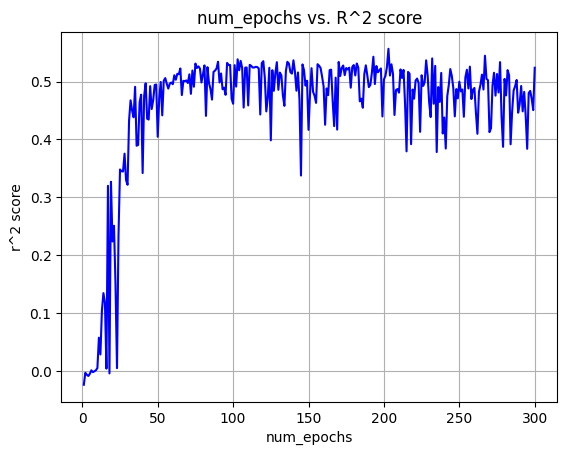

In [25]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [26]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5566048496636494
Corresponding RMSE: 0.20164128256023883
Corresponding num_epochs: 203
